In [ ]:
#!pip install chaospy
#!pip install numpy
#!pip install --tupgrade numpoly chaospy
#!pip uninstall openpyxl
#!pip install openpyxl

#!pip uninstall numpy
#!pip install numpy==1.20

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from scipy.io import loadmat
import spgl1 as spg
import numpy as np
import pandas as pd
from matplotlib import pyplot
import chaospy as cp 

In [41]:
dff = pd.read_excel('input_G2.xlsx')
arr = dff.to_numpy()
sample = arr.T
# Stochastic dimension (number of variables sampled)
dd = sample.shape[0]

# Number of samples
num_samp = sample.shape[1]

sample=sample.T
evaluation = pd.read_excel('stiffness_G2.xlsx')
evaluation = np.reshape(evaluation, -1) 
print(sample[0:3,:])
print(evaluation[0:3])
sample.shape

[[0.56527629 0.43942587 0.03358098 0.53883797]
 [0.51545407 0.5277173  0.01396743 1.01025584]
 [0.48130405 0.40711675 0.02986184 0.78446805]]
[0.42788928 0.24770509 1.04569222]


(9999, 4)

In [42]:
from sklearn.model_selection import train_test_split
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sample, evaluation, test_size=0.3, random_state=42, shuffle=False)


In [43]:
# standardize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0:3,:]

array([[ 0.65334235, -0.60584825,  0.57242266, -0.94235024],
       [ 0.15488868,  0.27732479, -0.73626481,  0.85965952],
       [-0.1867702 , -0.92903407,  0.32426762, -0.00342146]])

In [44]:
#distribution = cp.Iid(cp.Normal(0, 1), 2)
distribution_l = cp.Uniform(-1, 1)
distribution_h = cp.Uniform(-1, 1)
distribution_t = cp.Uniform(-1, 1)
distribution_theta = cp.Uniform(-1, 1)

distribution_joint=cp.J(distribution_l,distribution_h,distribution_t,distribution_theta)


In [61]:
# Choose polynomial order
poly_order = 5

# Construct PC expansion 
#poly_expansion = cp.orth_ttr(poly_order, dist)
poly_expansion = cp.expansion.stieltjes(poly_order, distribution_joint)

## Fit pc expansion to data. Chaospy default is least squares.
model_appr_cp = cp.fit_regression(poly_expansion, X_train_scaled.T, y_train)

In [62]:
# Calculate PC coefficients and compute validation error
from sklearn.metrics import r2_score

phi_1 = poly_expansion(*X_train_scaled.T).T
print(phi_1.shape)
ptp_1 = phi_1.T @ phi_1
print(ptp_1.shape)
pty_1 = phi_1.T @ y_train
print(y_train.shape)
c_hat_1 = np.linalg.inv(ptp_1) @ pty_1 

# validation error : test for data after train_num
phi_val_1 = poly_expansion(*X_test_scaled.T).T
val_est_1 = phi_val_1 @ c_hat_1      #equivalent to: val_test=model_appr_cp(*sample[:,12000:]).T

r2=r2_score(y_test, val_est_1)
val_error_1 = np.linalg.norm(y_test - val_est_1)/np.linalg.norm(y_test) 
print(val_error_1)
print(r2)
print(val_est_1)
print(y_test)

(6999, 126)
(126, 126)
(6999,)
0.008412897120005786
0.9998862772571767
[2.82723316 0.47701439 0.54773212 ... 0.47632116 2.76149887 8.36238506]
[2.82961245 0.47912121 0.54747761 ... 0.47905006 2.76253864 8.38448826]


In [65]:
# TEST A RANDOM ARRAY
# l=0.5, h=0.5 , t=0.06 , theta=0.6 ; note that t is outside train range
test_array= np.array([0.5, 0.5, 0.06, 0.6]).reshape(1, -1)
test_array=scaler.transform(test_array)
test_array
test_array=test_array.T
test_array.shape

val_test=model_appr_cp(*test_array).T
val_test

array([4.73737581])

In [73]:
from SALib.sample import saltelli
from SALib.analyze import sobol


problem = {
    'num_vars': 4,
    'names': ['l','h','t','theta'],
    'bounds': [[-1,1]*4]
}

#If `calc_second_order` is False, the resulting matrix has ``N * (D + 2)`` rows, 
#where ``D`` is the number of parameters. If `calc_second_order` is `True`, the resulting matrix has ``N * (2D + 2)`` rows.
param_values = saltelli.sample(problem, 10024, calc_second_order = True)    


C:\Users\fhassani\AppData\Local\Temp\ipykernel_9816\4058963038.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 10024, calc_second_order = True)


In [74]:
Y = np.zeros([param_values.shape[0]])
Y = model_appr_cp(*param_values.T)    

# Perform Sobol Analysis
Si = sobol.analyze(problem, Y)     


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[             ST   ST_conf
l      0.240856  0.017191
h      0.007089  0.000611
t      0.672729  0.042779
theta  0.375402  0.023550,              S1   S1_conf
l      0.107905  0.012912
h      0.003315  0.002386
t      0.430891  0.026992
theta  0.183765  0.019887,                   S2   S2_conf
(l, h)     -0.002726  0.023367
(l, t)      0.072640  0.032648
(l, theta)  0.030275  0.030551
(h, t)      0.001053  0.004979
(h, theta) -0.000883  0.005233
(t, theta)  0.134957  0.050475]


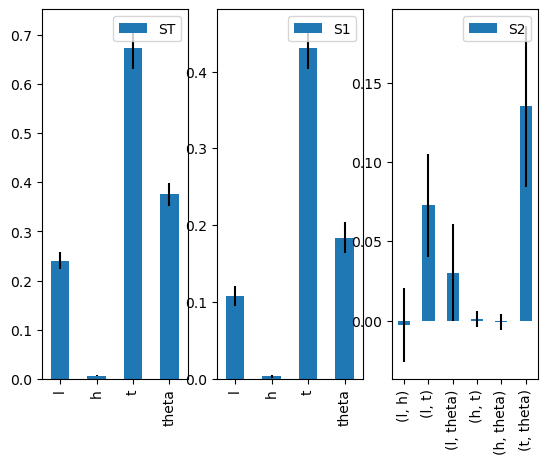

In [75]:
# Turn output to a Pandas DataFrame for further analysis
total_Si, first_Si, second_Si = Si.to_df()
Si.plot()
print(Si.to_df())